## IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')  # For tokenizers
nltk.download('stopwords')  # For stopwords
nltk.download('wordnet')  # For lemmatization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
# Standard Dropout (for dense/fully connected layers)
from tensorflow.keras.layers import Dropout

# Spatial Dropout (for convolutional/RNN layers)
from tensorflow.keras.layers import SpatialDropout1D  # 1D data (e.g., sequences)
from tensorflow.keras.layers import SpatialDropout2D  # 2D data (e.g., images)
from tensorflow.keras.layers import SpatialDropout3D  # 3D data (e.g., volumes)

from tensorflow.keras.layers import TextVectorization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## DATASET

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
df = pd.read_csv('/content/automated essay score.csv.csv')
df

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


## EDA (Exploratory Data Analysis)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
df.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
df.isnull().sum()

,0
essay_id,0
full_text,0
score,0


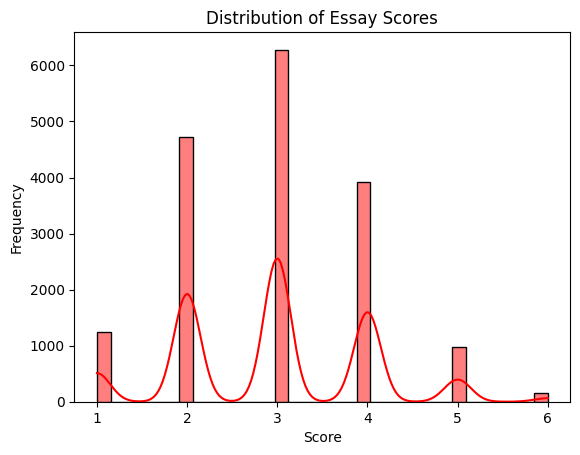

In [47]:
sns.histplot(df['score'], kde=True, color='red')
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

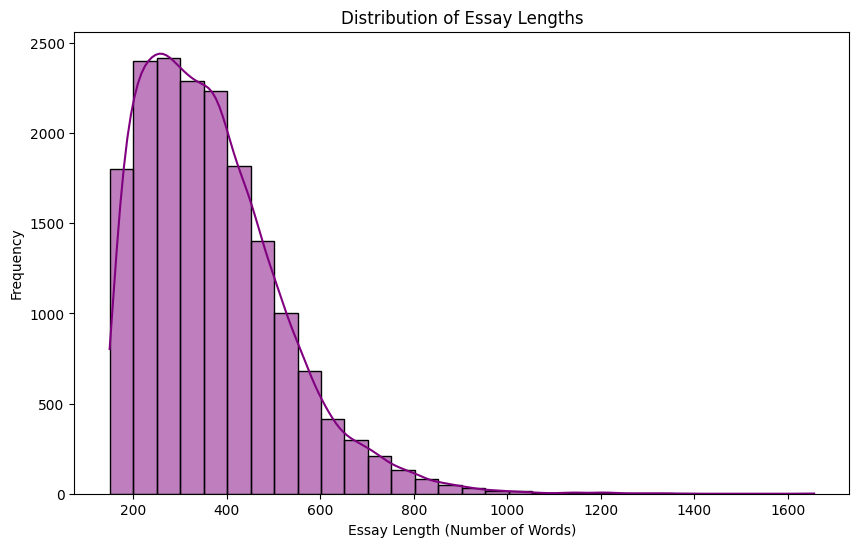

In [48]:
df['essay_length'] = df['full_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['essay_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stop_words(essay):
    word_tokens = word_tokenize(essay)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [ ]:
def preprocess_text(essay):
    essay = re.sub(r'\d+', '', essay)
    essay = re.sub(r'[^\w\s]', '', essay)
    tokens = word_tokenize(essay.lower())
    return tokens

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
df['clean_essay'] = df['full_text'].apply(lambda x:remove_stop_words(x))

In [ ]:
df['clean_essay'] = df['clean_essay'].apply(preprocess_text)

In [46]:
df['clean_essay'].head()

,clean_essay
0,"[many, people, car, live, the, thing, nt, know..."
1,"[i, scientist, nasa, discussing, face, mars, i..."
2,"[people, always, wish, technology, seen, movie..."
3,"[we, heard, venus, planet, without, almost, ox..."
4,"[dear, state, senator, this, letter, argue, fa..."


## LSTM Model

In [ ]:
# Tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_essay'])
X = tokenizer.texts_to_sequences(df['clean_essay'])
X = pad_sequences(X, maxlen=200)
Y = df['score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
def model():
    model= Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    return model

In [ ]:
lstm_model = model()
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['r2_score'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = lstm_model.fit(X_train ,y_train,batch_size=32, validation_split=0.2, epochs=5)

Epoch 1/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 315s 881ms/step - loss: 2.1193 - r2_score: -0.9757 - val_loss: 0.7774 - val_r2_score: 0.2922
Epoch 2/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 320s 877ms/step - loss: 0.9741 - r2_score: 0.1056 - val_loss: 0.7186 - val_r2_score: 0.3457
Epoch 3/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 301s 869ms/step - loss: 0.7871 - r2_score: 0.2717 - val_loss: 0.6011 - val_r2_score: 0.4527
Epoch 4/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 322s 870ms/step - loss: 0.6702 - r2_score: 0.3960 - val_loss: 0.5534 - val_r2_score: 0.4962
Epoch 5/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 313s 843ms/step - loss: 0.6664 - r2_score: 0.3897 - val_loss: 0.4823 - val_r2_score: 0.5609


In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = lstm_model.predict(X_test).flatten()
y_pred = np.rint(y_pred)

kappa_score = cohen_kappa_score(y_test, y_pred)
print(f'Cohen Kappa Score: {kappa_score}')


109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step
Cohen Kappa Score: 0.36215157355725036


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

y_pred = lstm_model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step
R² Score: 0.556462287902832


In [53]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = lstm_model.predict(X_test).flatten()
y_pred = np.rint(y_pred)

kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Quadratic Weighted Kappa: {kappa_score}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step
Quadratic Weighted Kappa: 0.660134876749619


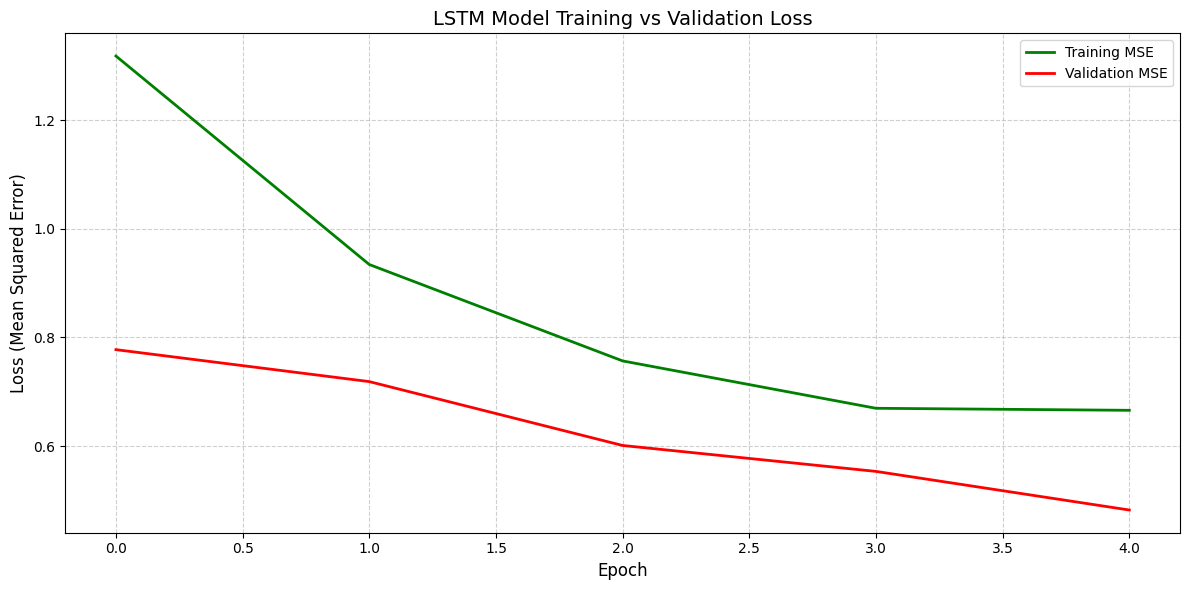

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training MSE', color='green', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation MSE', color='red', linewidth=2)
plt.title('LSTM Model Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## GRU Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, SpatialDropout1D

# Define the GRU model
def model():
    model_gru = Sequential()
    model_gru.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
    model_gru.add(SpatialDropout1D(0.2))
    model_gru.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model_gru.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
    model_gru.add(Dense(32, activation='relu'))
    model_gru.add(Dropout(0.2))
    model_gru.add(Dense(1, activation='linear'))
    return model_gru

In [ ]:
model_gru = model()
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['r2_score'])

history_gru = model_gru.fit(X, Y, epochs=15, batch_size=50, validation_split=0.2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


277/277 ━━━━━━━━━━━━━━━━━━━━ 262s 913ms/step - loss: 2.4038 - r2_score: -1.2085 - val_loss: 0.5324 - val_r2_score: 0.5071
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 249s 899ms/step - loss: 0.6377 - r2_score: 0.4152 - val_loss: 0.4549 - val_r2_score: 0.5788
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 251s 905ms/step - loss: 0.5543 - r2_score: 0.4931 - val_loss: 0.5336 - val_r2_score: 0.5060
Epoch 4/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 261s 900ms/step - loss: 0.5137 - r2_score: 0.5310 - val_loss: 0.4721 - val_r2_score: 0.5629
Epoch 5/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 263s 907ms/step - loss: 0.4815 - r2_score: 0.5613 - val_loss: 0.4972 - val_r2_score: 0.5396
Epoch 6/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 262s 906ms/step - loss: 0.4420 - r2_score: 0.6019 - val_loss: 0.4557 - val_r2_score: 0.5781
Epoch 7/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 260s 901ms/step - loss: 0.4032 - r2_score: 0.6342 - val_loss: 0.4601 - val_r2_score: 0.5740
Epoch 8/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 263s 904ms/step - loss: 0.3781 - r2_score: 0.6

In [ ]:
model_gru.save("gru_essay_model.h5")

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

y_pred = model_gru.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step
R² Score: 0.812390923500061


In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = model_gru.predict(X_test).flatten()
y_pred = np.rint(y_pred)

kappa_score = cohen_kappa_score(y_test, y_pred)
print(f'Cohen Kappa Score: {kappa_score}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step
Cohen Kappa Score: 0.7202498736038498


In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = model_gru.predict(X_test).flatten()
y_pred = np.rint(y_pred)

kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Quadratic Weighted Kappa: {kappa_score}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step
Quadratic Weighted Kappa: 0.878194565579876


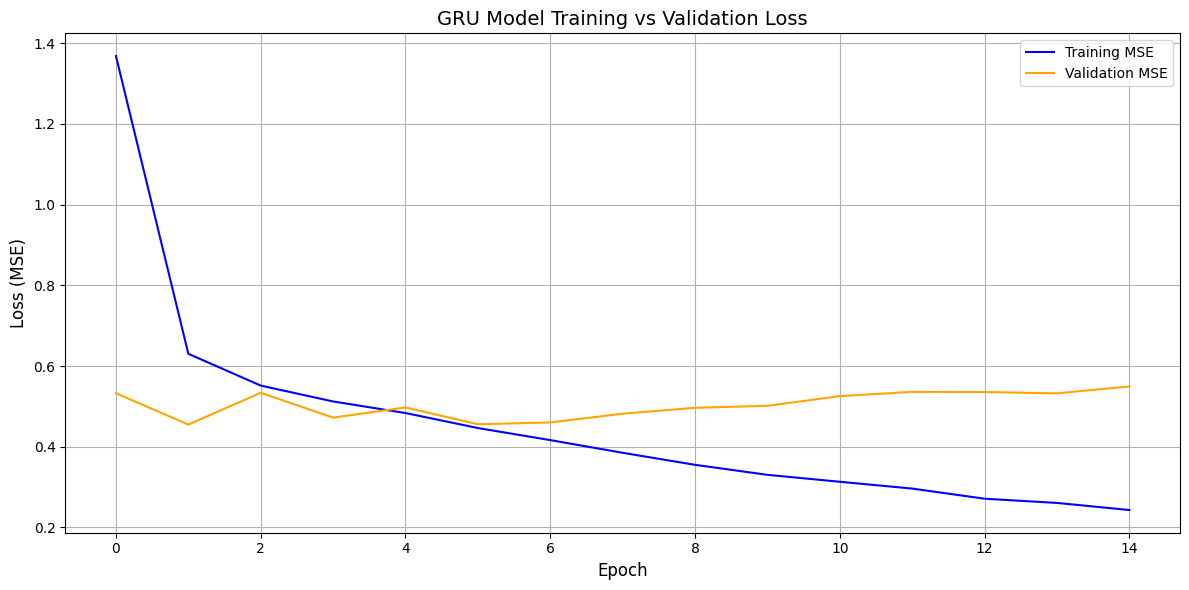

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Training MSE', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation MSE', color='orange')
plt.title('GRU Model Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q streamlit pyngrok
!ngrok config add-authtoken 2yzpOljdTtfbTB7Escht347G1TI_oy9anR2XBWzLiYUd5Mjg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [51]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

text_data = [
    "Education is the key to success.",
    "Climate change is a global concern.",
    "Technology connects people around the world.",
]

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(text_data)

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ tokenizer.pkl saved successfully!")


✅ tokenizer.pkl saved successfully!


In [ ]:
from google.colab import files
files.download("tokenizer.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from google.colab import files
uploaded = files.upload()


Saving gru_essay_model.h5 to gru_essay_model (3).h5
Saving tokenizer.pkl to tokenizer (2).pkl


In [43]:
%%writefile streamlit_app.py
import streamlit as st
import numpy as np
import re
import string
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 200

try:
    model = load_model("gru_essay_model.h5")
except:
    st.error(" Model file not found. Upload 'gru_essay_model.h5'.")

try:
    tokenizer = pickle.load(open("tokenizer.pkl", "rb"))
except:
    st.error(" Tokenizer file not found. Upload 'tokenizer.pkl'.")

def preprocess_essay(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

st.set_page_config(page_title="Essay Score Predictor", layout="centered")
st.title("📘 Automated Essay Score Predictor")
st.markdown("Enter your essay below and receive an AI-generated score based on content length and quality.")

essay = st.text_area("✍️ Write your essay here:", height=300)

if st.button("📊 Predict Score"):
    if essay.strip() == "":
        st.warning("Essay cannot be empty.")
    else:
        cleaned_essay = preprocess_essay(essay)
        word_count = len(cleaned_essay.split())

        if word_count < 50:
            st.error("Essay is too short to evaluate. Please write at least 50 words.")
        else:
            sequence = tokenizer.texts_to_sequences([cleaned_essay])
            padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
            score = model.predict(padded, verbose=0)[0][0]
            rounded_score = round(float(score), 2)

            st.success(f"📝 Word Count: {word_count}")
            st.success(f"📈 Predicted Essay Score: **{rounded_score}**")

            if rounded_score >= 4:
                st.balloons()


Overwriting streamlit_app.py


In [45]:
from pyngrok import ngrok
import os
import time

ngrok.kill()

os.system('streamlit run streamlit_app.py &')

time.sleep(3)

public_url = ngrok.connect(8501)
print(f"✅ Streamlit app is live at: {public_url}")


✅ Streamlit app is live at: NgrokTunnel: "https://214e-35-196-108-86.ngrok-free.app" -> "http://localhost:8501"
